(sec:reinforcement-learning)=
# 強化学習の基礎

In [ ]:
"""
下準備のコード
"""

import random

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

try:
    from myst_nb import glue
except ImportError:
    glue = lambda *args, **kwargs: None

# スロットアームの数
n_arms = 5
glue("n_arms", n_arms)

# 試行回数
n_play = 20000
glue("n_play", n_play)

# シード値の設定
random.seed(31415)
np.random.seed(31415)

# グラフの設定
rc = {
    "figure.dpi": 150,
    "axes.linewidth": 1,
    "axes.edgecolor": "black",
    "grid.color": "gray",
    "grid.linestyle": "--",
    "grid.linewidth": 0.5,
    "xtick.major.size": 2,
    "ytick.major.size": 2,
    "legend.frameon": True,
    "legend.borderpad": 0.5,
    "legend.facecolor": "white",
    "legend.edgecolor": "black",
    "legend.framealpha": 1.0,
}
sns.set_theme(style="whitegrid", palette="colorblind", rc=rc)

5

20000

強化学習とは、何らかの目的を達成するために、「行動」と「評価」を繰り返しながら、より良い行動を取ることを目指す機械学習法である。

これまで取り扱ってきた教師あり学習が「正解に近づく」ように学習を行うのに対し、強化学習は **「報酬が最大となる」** ように学習を行う。

今回は、「多腕バンディット問題」を題材に、強化学習の基礎について紹介する。

## 多腕バンディット問題

**多腕バンディット問題**とは、スロットゲームを題材に、得られる報酬の量を最大にする問題である。

今、スロットに複数のアームが取り付けられており、各アームが当たり確率を出すかは未知である。このような状況下で、スロットを決まった回数だけ回して、当たり確率を推定しながら、より多くの当たりを出すスロットを回す。

この問題では、**当たり確率の推定精度を上げる**ことと、**当たりが多く出そうなスロットを回す**という二つの問題を同時に解く必要がある。本資料では、これらの目的を目指す行動を、それぞれ**探査**と**知識利用**と呼ぶ。

探査と知識利用は、相反する行動で、より当たり確率の推定精度を上げようとすれば、例えば、一見当たりが出なさそうにみえるスロットも、もう少し回した方が良い可能性がある。

一方で、推定精度の向上に拘泥しすぎると、当たりが多く出そうなスロットを回す回数が減ってしまい、結果として得られる報酬が減ってしまう。

### スロットゲームの実装

まずは、多腕バンディット問題を扱うために、スロットゲームを実装してみる。スロット台のアームを表わす `SlotArm`というクラスを以下のように実装する。

In [ ]:
class SlotArm(object):
    """
    スロットアームを表わすクラス
    """

    def __init__(self, ratio=0.5, seed=None):
        """
        ratio: 当たり確率
        seed: 乱数のシート値
        """
        self.ratio = ratio
        self.rng = np.random.RandomState(seed)

    def draw(self):
        """
        アームを回し、当たりならばTrue, 外れならばFalseを返す
        """
        return self.rng.uniform(0.0, 1.0) < self.ratio

この`SlotArm`クラスを配列として、スロット台のアームを複数用意する。

以下の例では、{glue:}`n_arms`本のアームを持つスロット台を用意し、各アームが当たりを出す確率が0.1から0.2刻みで0.9までになるように設定する。

なお、**これらの当たり確率は未知の値である**。

In [ ]:
# 0.1-0.9までの当たり確率を0.2刻みで設定
ratios = np.linspace(0.1, 0.9, n_arms, endpoint=True)
# その後、順番をランダムに入れ替える
ratios = np.random.permutation(ratios)
print(f"Ratios: {ratios}")

Ratios: [0.1 0.7 0.3 0.5 0.9]


In [ ]:
# 用意した当たり確率を用いてスロットアームをインスタンス化
arms = [SlotArm(ratio=ratio) for ratio in ratios]

In [ ]:
glue("avg_ratio", np.mean(ratios))
glue("best_ratio", np.max(ratios))

0.5

0.9

このようにアームの当たり確率を割り当てた場合、平均の当たり確率は{glue:}`avg_ratio`であり、当たり確率最大のアームの当たり確率は{glue:}`best_ratio`である。

以下にアーム選択の戦略のいくつかを示すが、各戦略は

- 平均の当たり確率より有意に大きな平均当たり確率を実現
- 当たり確率の値を最大の当たり確率にできる限り近づける

という二つの目的の実現を目指している。

## ランダムな方策選択

強化学習において、何らかの行動を取ることを**方策**と呼ぶ。

まずは、上記の問題設定で、ランダムにアームを選んでスロットを回すという方策をとった場合に、どの程度の当たりが出るかを見てみよう。

以下の実験では{glue:}`n_play`回スロットをプレイできるとして実験を行う。

In [ ]:
history = []
for i in range(n_play):
    # ランダムに1つのスロットを選ぶ
    k = np.random.randint(0, n_arms)

    # 当たり外れを記録
    if arms[k].draw():
        history.append(1.0)
    else:
        history.append(0.0)

こちらの例で `history` には{glue:}`n_play`回の各試行が当たりならば1が、外れならば0が格納されている。この値を用いて、**平均の当たり確率**と**当たり確率の標準偏差**の変移を計算する。

In [ ]:
history = np.array(history)  # 各試行の当たり外れの履歴
accum = np.cumsum(history)  # 累積当たり回数

play_count = np.arange(1, n_play + 1)  # 試行回数
E_rand = accum / play_count  # 当たり確率
S_rand = np.sqrt((history - E_rand) ** 2.0 / play_count)  # 推定当たり確率の標準偏差

In [ ]:
glue("random_ratio", E_rand[-1])

0.4996

:::{admonition} 結果: ランダムな方策選択
:class: note

当たり確率: {glue:text}`random_ratio:.3f`
:::

以下には、横軸にスロットを回した回数を取り、当たり確率とその推定値分散をプロットしたものを示す。

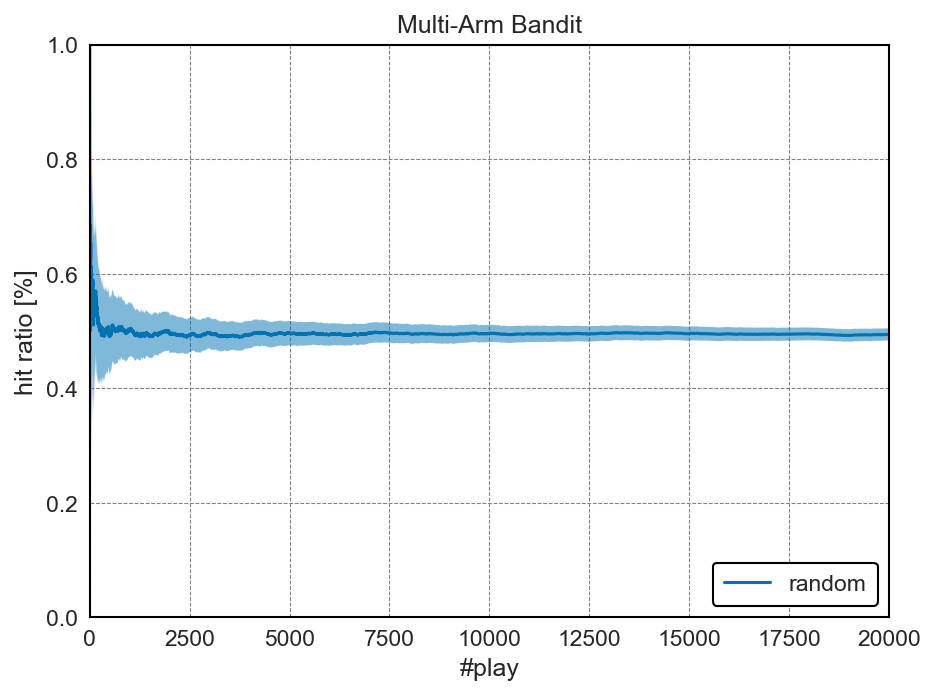

In [ ]:
fig, ax = plt.subplots()

ax.fill_between(
    np.arange(n_play),
    E_rand - S_rand * 3.0,
    E_rand + S_rand * 3.0,
    alpha=0.5,
    linewidth=0,
)
ax.plot(np.arange(n_play), E_rand, label="random")

ax.set_xlim(0, n_play)
ax.set_ylim(0.0, 1.0)
ax.set_xlabel("#play")
ax.set_ylabel("hit ratio [%]")
ax.set_title("Multi-Arm Bandit")

ax.legend(loc="lower right")
fig.tight_layout()

glue("random_plot", fig)
plt.close()

:::{glue:figure} random_plot
:figclass: image-stylish
:::

このように、ランダムに回すと、得られる報酬は、当たり確率の{glue:text}`avg_ratio`程度に張り付くことが分かる。

## 貪欲法

報酬を増やすためにあり得そうな方法は、 **一番当たっているスロットを常に回す** という方策である。この手法を**貪欲法**と呼ぶ。

以下に、各スロットの現在の当たり確率を保存しておいて、それが最大になるものを回すようにプログラムを示す。

ただし、最初の数回は当たり確率が安定しない可能性があるので、最初の10%は、ランダムに回している。このように最初の何回かを乱数による影響を除去するためにランダム試行する操作を**バーンイン**と呼ぶ。

In [ ]:
# バーンインの回数
n_burn_in = n_play // 10

# 当たり外れの履歴、当たり回数、プレイ回数を記録
history = []
n_arm_hit = np.zeros(n_arms)
n_arm_play = np.zeros(n_arms)
for i in range(n_play):
    # まだ回していないアームがあれば、それを回す
    for k in range(n_arms):
        if n_arm_play[k] == 0:
            break
    else:
        if i < n_burn_in:
            # バーンイン中ならランダムに回す
            k = np.random.randint(0, n_arms)
        else:
            # そうでなければ、当たり確率が最大のものを回す
            ratios = n_arm_hit / n_arm_play
            k = np.argmax(ratios)

    # 選んだアームを回す
    if arms[k].draw():
        history.append(1.0)
        n_arm_hit[k] += 1
    else:
        history.append(0.0)

    n_arm_play[k] += 1

history = np.array(history)
accum = np.cumsum(history)

play_count = np.arange(1, n_play + 1)
E_greedy = accum / play_count
S_greedy = np.sqrt((history - E_greedy) ** 2.0 / play_count)

In [ ]:
glue("greedy_ratio", E_greedy[-1], display=False)

:::{admonition} 結果: 貪欲法
:class: note

当たり確率: {glue:text}`greedy_ratio:.3f`
:::


以下には得られた平均報酬の比較を示す。

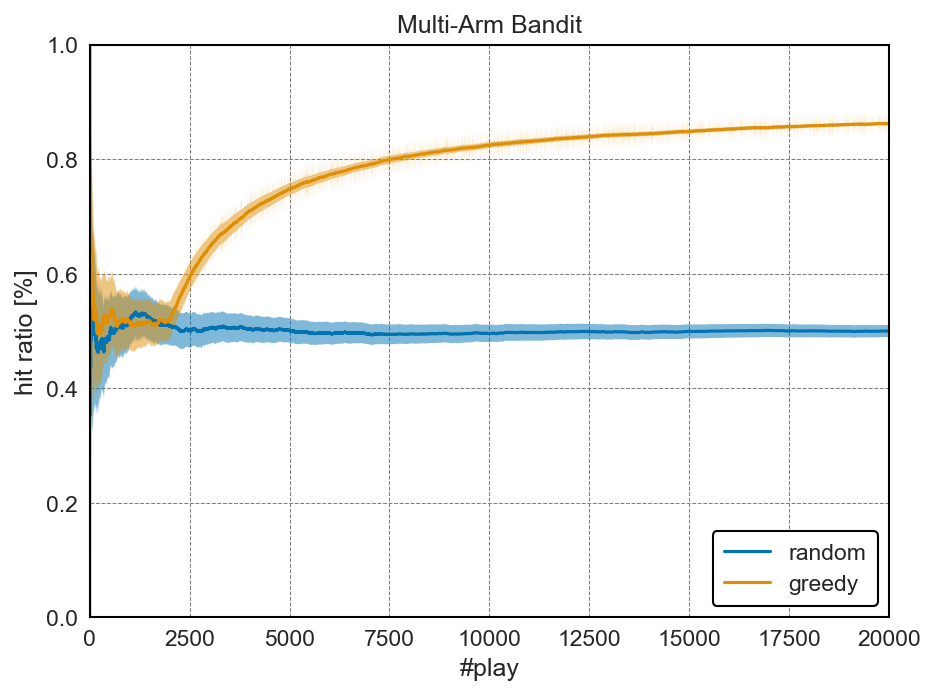

In [ ]:
fig, ax = plt.subplots()

ax.fill_between(
    play_count,
    E_rand - S_rand * 3.0,
    E_rand + S_rand * 3.0,
    alpha=0.5,
    linewidth=0,
)
ax.plot(play_count, E_rand, label="random")

ax.fill_between(
    play_count,
    E_greedy - S_greedy * 3.0,
    E_greedy + S_greedy * 3.0,
    alpha=0.5,
    linewidth=0,
)
ax.plot(play_count, E_greedy, label="greedy")

ax.set_xlim(0, n_play)
ax.set_ylim(0.0, 1.0)
ax.set_xlabel("#play")
ax.set_ylabel("hit ratio [%]")
ax.set_title("Multi-Arm Bandit")

ax.legend(loc="lower right")
fig.tight_layout()

glue("greedy_plot", fig)
plt.close()

:::{glue:figure} greedy_plot
:figclass: image-stylish
:::

上記の結果を見てみると、一番当たっている物を回す、という戦略はそれほど悪くはないように見える。

実際、最終的な報酬は、最も当たりやすいスロットの当たり確率である{glue:text}`best_ratio:.2f`に近づいている。

しかし、**最初の10%を回した時点の当たり確率の推定値にその後の報酬が強く依存**する上、**ランダムに回す最初の10%の試行で得られる報酬は有意に増加しない**。

また、今回はスロットの当たり確率にそれなりに差があるため、全体の試行回数の10%程度で、一番当たるスロットがどれかが判明するが、実際には当たり確率が非常に近い場合もあり、貪欲法には依然改善の余地がある。

## $\varepsilon$-greedy法

$\varepsilon$-greedy法は、とある定数 $0 < \varepsilon < 1$ について、$\varepsilon$の確率でランダムにスロットを選び、 $1 - \varepsilon$ の確率で一番当たっているスロットを回す、という方法である。

一例として $\varepsilon$の値が常に0.1の場合には、先ほどランダムに10%の試行回数をバーンインに用いたものとそれほど変わらないように思える。

しかし、最初の10%を完全にランダムに回すという貪欲法の戦略は、**本当はもう少し早い段階で一番当たりそうなスロットが判明しているかもしれない**のに、それを無視してしまうことになる。

そのため、現在分かっている情報をできるだけ有効活用しよう、というのが$\varepsilon$-greedy法の考え方である。

In [ ]:
epsilon = 0.1

history = []
n_arm_hit = np.zeros(n_arms)
n_arm_play = np.zeros(n_arms)
for i in range(n_play):
    for k in range(n_arms):
        if n_arm_play[k] == 0:
            break
    else:
        u = np.random.uniform(0.0, 1.0)
        if u < epsilon:
            k = np.random.randint(0, n_arms)
        else:
            ratios = n_arm_hit / n_arm_play
            k = np.argmax(ratios)

    if arms[k].draw():
        history.append(1.0)
        n_arm_hit[k] += 1
    else:
        history.append(0.0)

    n_arm_play[k] += 1

history = np.array(history)
accum = np.cumsum(history)

play_count = np.arange(1, n_play + 1)
E_eps = accum / play_count
S_eps = np.sqrt((history - E_eps) ** 2.0 / play_count)

In [ ]:
glue("eps_ratio", E_eps[-1])

0.85965

:::{admonition} 結果: $\varepsilon$-greedy法
:class: note

当たり確率: {glue:text}`eps_ratio:.3f`

:::


以下には得られた平均報酬の比較を示す。

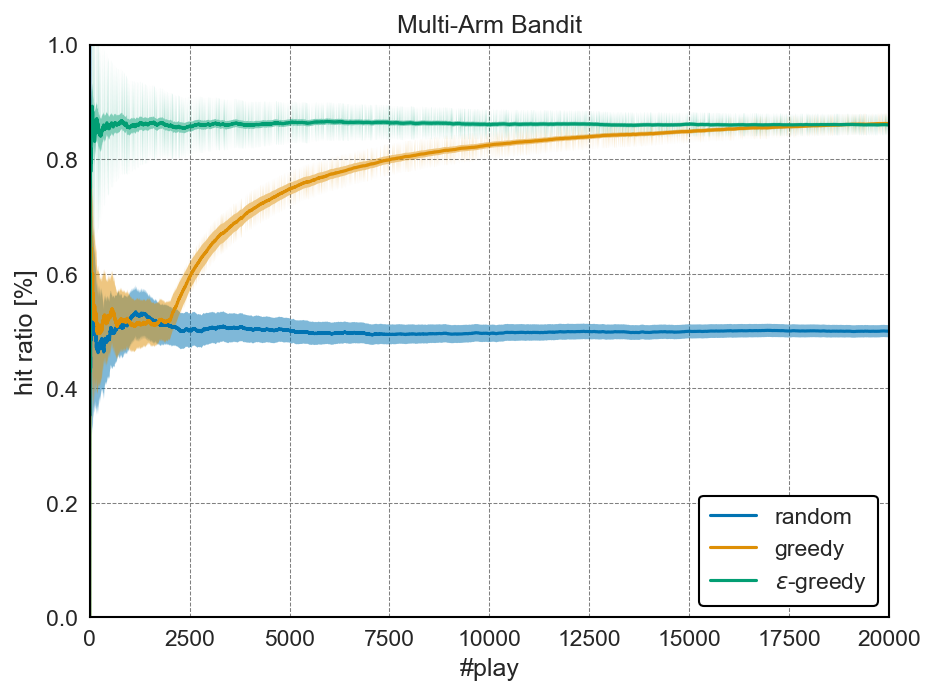

In [ ]:
fig, ax = plt.subplots()

ax.fill_between(
    play_count,
    E_rand - S_rand * 3.0,
    E_rand + S_rand * 3.0,
    alpha=0.5,
    linewidth=0,
)
ax.plot(play_count, E_rand, label="random")

ax.fill_between(
    play_count,
    E_greedy - S_greedy * 3.0,
    E_greedy + S_greedy * 3.0,
    alpha=0.5,
    linewidth=0,
)
ax.plot(play_count, E_greedy, label="greedy")

ax.fill_between(
    play_count,
    E_eps - S_eps * 3.0,
    E_eps + S_eps * 3.0,
    alpha=0.5,
    linewidth=0,
)
ax.plot(play_count, E_eps, label="$\epsilon$-greedy")

ax.set_xlim(0, n_play)
ax.set_ylim(0.0, 1.0)
ax.set_xlabel("#play")
ax.set_ylabel("hit ratio [%]")
ax.set_title("Multi-Arm Bandit")

ax.legend(loc="lower right")
fig.tight_layout()

glue("eps_greedy_plot", fig)
plt.close()

:::{glue:figure} eps_greedy_plot
:figclass: image-stylish
:::

この結果から分かるように、完全にランダムに回す、というのをやめるだけで、試行回数が少ない段階から、かなり高い平均当たり確率が得られていることが分かる。

一方で、 $\varepsilon$-greedy法で得られる当たり確率は平均の当たり確率を $\bar{P}$, 最大の当たり確率を $P_{\rm max}$としたときに、 

$$
P_{\varepsilon \text{-greedy}} = \varepsilon \bar{P} + (1 - \varepsilon) P_{\rm max}
$$

に近づくと考えられる。

このように、得られる平均の当たり確率が試行回数を増やしても $P_{\rm max}$ に近づいて行かないという点は改善の余地がある。

::::{admonition} 問
:class: question

$\varepsilon$-greedy法においては、通常、試行回数が増えれば増えるほど、各スロットの当たり確率の推定値が真値に近づいていくので、$\varepsilon$の値は、試行回数とともに徐々に小さくしていくことが多い。

上記の例では$\varepsilon$の値を常に0.1としていたが、$\varepsilon=0.5$を初期値とし、最終{glue:}`n_play`回の時に$\varepsilon=0.001$となるように等比数列的に$\varepsilon$の値を下げていくと性能がどのように変化するかを調べよ。

::::

## ソフトマックス探索

$\varepsilon$-greedy法でも十分に良い結果が得られているが、探査のために完全なランダム行動を取る、という点には、まだ改善の余地がある。

例えば、スロットの当たり確率が0.05のスロットも、この時にランダムに選ばれてしまう点はマイナスである。

そこで、ランダムな探査の代わりに、現在の推定当たり確率から求まる評価関数によって、探査行動の選択を考える。

このような評価関数の一つにソフトマックス関数があり、これにより評価関数を定義する手法を**ソフトマックス探索**と呼ぶ。

ソフトマックス関数は、$i$番目のスロットに対して求まっている当たり確率の期待値が$q_i$であるとしたときに、スロットの評価値$v_i$を以下のように定義される。

$$
v_i = \frac{e^{q_i}}{\sum_{j=1}^N e^{q_j}}
$$

また、より自由度の高い定義として、温度パラメータ $\tau$を用いて、評価関数を次式のように定義する場合もある。

$$
v_i = \frac{e^{q_i / \tau}}{\sum_{j=1}^N e^{q_j / \tau}}
$$

この定義はBolzmann関数と呼ばれるため、ソフトマックス関数は**Boltzmann探索**と呼ばれることもある。

ソフトマックス関数により得られる評価値は0から1の間の実数を取り、全てのスロットの評価値の合計は1となる。この時、仮に当たり確率の期待値が0であっても、ある程度の割合で選択され、一方で、確率としては、より当たり確率が高いものを相対的に多く選ぶという意味で、ランダム性と当たり確率の利用のバランスが良い。

In [ ]:
def boltzmann(x, tau=1.0):
    """Boltzmann関数"""
    x = x / tau
    x = x - np.max(x, axis=0)
    return np.exp(x) / np.sum(np.exp(x), axis=0)

In [ ]:
history = []
n_arm_hit = np.zeros(n_arms)
n_arm_play = np.zeros(n_arms)
for i in range(n_play):
    for k in range(n_arms):
        if n_arm_play[k] == 0:
            break
    else:
        ratios = n_arm_hit / n_arm_play
        ratios = boltzmann(ratios)
        k = np.argmax(ratios)

    if arms[k].draw():
        history.append(1.0)
        n_arm_hit[k] += 1
    else:
        history.append(0.0)

    n_arm_play[k] += 1

history = np.array(history)
accum = np.cumsum(history)

play_count = np.arange(1, n_play + 1)
E_smax = accum / play_count
S_smax = np.sqrt((history - E_smax) ** 2.0 / play_count)

In [ ]:
glue("softmax_ratio", E_smax[-1], display=False)

:::{admonition} 結果: ソフトマックス探索
:class: note

当たり確率: {glue:text}`softmax_ratio:.3f`

:::

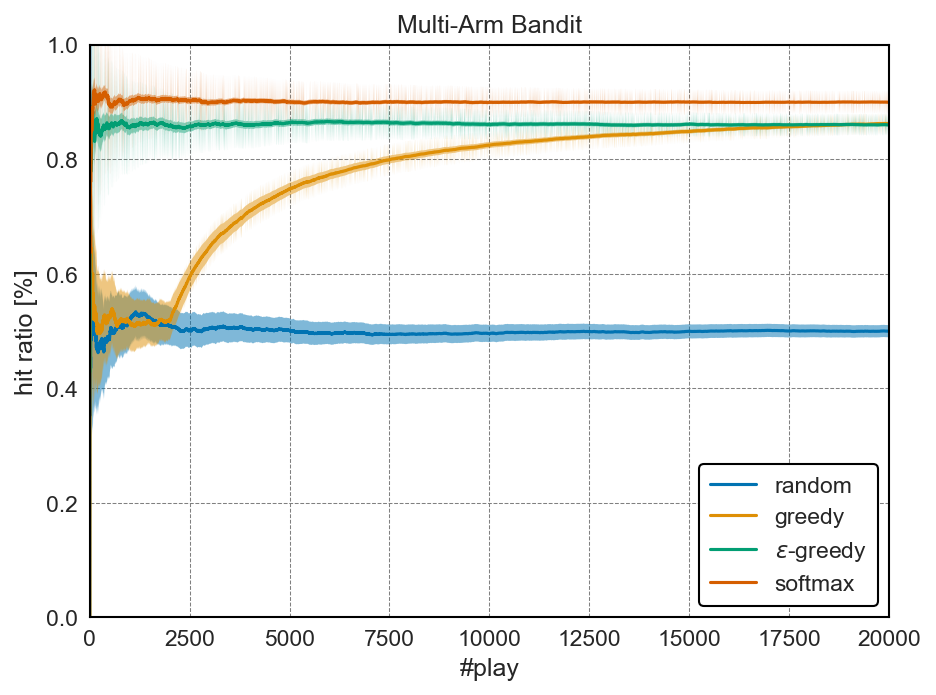

In [ ]:
fig, ax = plt.subplots()

ax.fill_between(
    play_count,
    E_rand - S_rand * 3.0,
    E_rand + S_rand * 3.0,
    alpha=0.5,
    linewidth=0,
)
ax.plot(play_count, E_rand, label="random")

ax.fill_between(
    play_count,
    E_greedy - S_greedy * 3.0,
    E_greedy + S_greedy * 3.0,
    alpha=0.5,
    linewidth=0,
)
ax.plot(play_count, E_greedy, label="greedy")

ax.fill_between(
    play_count,
    E_eps - S_eps * 3.0,
    E_eps + S_eps * 3.0,
    alpha=0.5,
    linewidth=0,
)
ax.plot(play_count, E_eps, label="$\epsilon$-greedy")

ax.fill_between(
    play_count,
    E_smax - S_smax * 3.0,
    E_smax + S_smax * 3.0,
    alpha=0.5,
    linewidth=0,
)
ax.plot(play_count, E_smax, label="softmax")

ax.set_xlim(0, n_play)
ax.set_ylim(0.0, 1.0)
ax.set_xlabel("#play")
ax.set_ylabel("hit ratio [%]")
ax.set_title("Multi-Arm Bandit")

ax.legend(loc="lower right")
fig.tight_layout()

glue("softmax_plot", fig)
plt.close()

:::{glue:figure} softmax_plot
:figclass: image-stylish
:::

上記の結果を見てみると、ソフトマックス探索の最終的な平均当たり確率は、ほとんど最大の当たり確率と同じ値になっている。

さらに、ソフトマックス法は**試行回数が少ない場合でも、安定して高い平均報酬が得られている**ことが分かる。

## Upper Confidence Bound (UCB)

先ほどのソフトマックス探索は、多腕バンディット問題のような、各試行によって当たり確率が変化しないような問題に対しては高い性能を示す一方、**その時々で当たり確率が変動するような対象に対しては、安定して作用しない**こと知られている。

また、ソフトマックス探索はソフトマックス関数により得られた次の試行を選ぶための確率密度分布が経験的に良い値になることを利用している。

だが、ソフトマックス関数を適用する前の現在の推定当たり確率に温度パラメータ $\tau$ を設定する余地があり、どの温度でソフトマックス関数を計算するのが最適なのかは問題に依存する。

このようなソフトマックス法の経験的な部分を、より理論的に補った手法に**UCB値を用いる手法** {cite}`auer2002finite`がある。UCB値にはいくつかの式が知られているが、最も一般的なUCB1は以下の式で表わされる。

$$
\text{UCB1}_i = \frac{n_{i,{\rm hit}}}{n_{i,{\rm play}}} + \sqrt{\frac{2 \log(n_{\rm total})}{n_{i, {\rm play}}}}
$$

この式で $n_{i,{\rm hit}}$ と $n_{i,{\rm play}}$ は、評価したいアームの当たり回数と試行回数を表し、 $n_{\rm total}$ は全アームの試行回数の合計を表わす。

UCB1値の第1項が単純なアームの当たり確率を表す。第２項はその推定値にどの程度の偏り(=バイアス)が含まれているかを表す。

バイアス項は総試行回数 $n_{\rm total}$ と比較して $n_{i, {\rm play}}$の値が相対的に小さいときに大きな値を取る。これは、他の方策に比べて、第1項の期待値の正確性が劣っており、そのような方策に対する探索行動の必要性を示す。

このようにUCB1は、推定の当たり確率が高いか、推定値の信頼性が低いアームをより多く回すという戦略を上手く表わしている。

In [ ]:
history = []
n_arm_hit = np.zeros(n_arms)
n_arm_play = np.zeros(n_arms)
for i in range(n_play):
    for k in range(n_arms):
        if n_arm_play[k] == 0:
            break
    else:
        n_total = i + 1
        ratios = n_arm_hit / n_arm_play
        bias = np.sqrt(2.0 * np.log(n_total) / n_arm_play)
        ucb = ratios + bias
        k = np.argmax(ucb)

    if arms[k].draw():
        history.append(1.0)
        n_arm_hit[k] += 1
    else:
        history.append(0.0)

    n_arm_play[k] += 1

history = np.array(history)
accum = np.cumsum(history)

play_count = np.arange(1, n_play + 1)
E_ucb = accum / play_count
S_ucb = np.sqrt((history - E_ucb) ** 2.0 / play_count)

In [ ]:
glue("ucb_ratio", E_ucb[-1], display=False)

:::{admonition} 結果: UCB1
:class: note

当たり確率: {glue:text}`ucb_ratio:.3f`
:::


以下には得られた平均報酬の比較を示す。

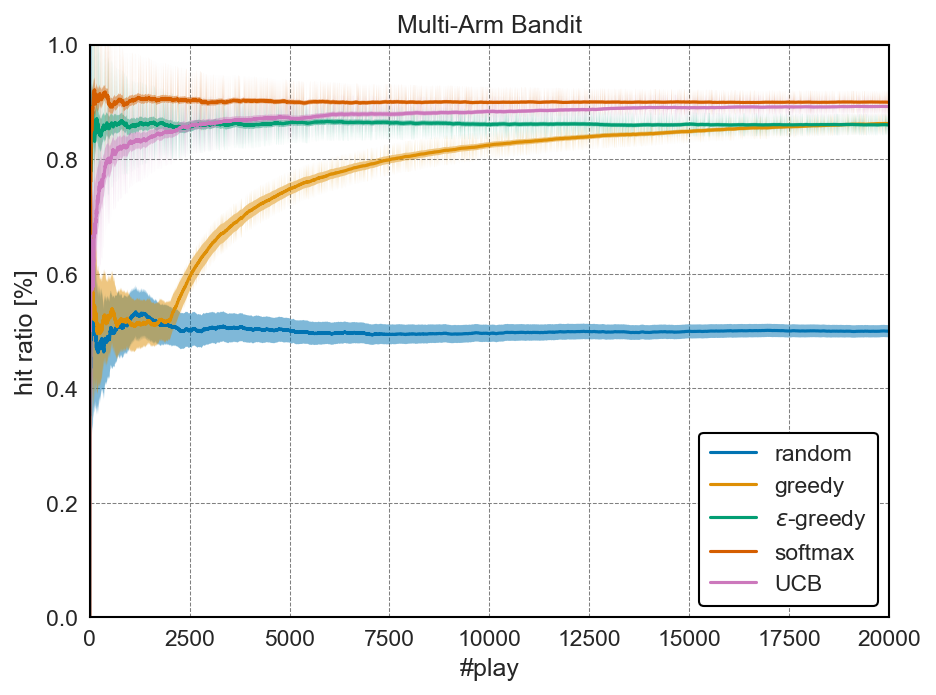

In [ ]:
fig, ax = plt.subplots()

ax.fill_between(
    play_count,
    E_rand - S_rand * 3.0,
    E_rand + S_rand * 3.0,
    alpha=0.5,
    linewidth=0,
)
ax.plot(play_count, E_rand, label="random")

ax.fill_between(
    play_count,
    E_greedy - S_greedy * 3.0,
    E_greedy + S_greedy * 3.0,
    alpha=0.5,
    linewidth=0,
)
ax.plot(play_count, E_greedy, label="greedy")

ax.fill_between(
    play_count,
    E_eps - S_eps * 3.0,
    E_eps + S_eps * 3.0,
    alpha=0.5,
    linewidth=0,
)
ax.plot(play_count, E_eps, label="$\epsilon$-greedy")

ax.fill_between(
    play_count,
    E_smax - S_smax * 3.0,
    E_smax + S_smax * 3.0,
    alpha=0.5,
    linewidth=0,
)
ax.plot(play_count, E_smax, label="softmax")

ax.fill_between(
    play_count,
    E_ucb - S_ucb * 3.0,
    E_ucb + S_ucb * 3.0,
    alpha=0.5,
    linewidth=0,
)
ax.plot(play_count, E_ucb, label="UCB")

ax.set_xlim(0, n_play)
ax.set_ylim(0.0, 1.0)
ax.set_xlabel("#play")
ax.set_ylabel("hit ratio [%]")
ax.set_title("Multi-Arm Bandit")

ax.legend(loc="lower right")
fig.tight_layout()

glue("ucb_plot", fig)
plt.close()

:::{glue:figure} ucb_plot
:figclass: image-stylish
:::

上記のようにUCB1は多腕バンディット問題のような、状態変化が少ない問題においてはソフトマックス探索に比べて最大当たり確率への収束が遅くなっているが、モデルを決定するパラメータがなく、状態変化が起こるモデルへの頑健性に優れている。

この点については、以後の[Q学習](sec:q-learning)の節などで各自で確認してみてほしい。

::::{admonition} 問
:class: question

UCBにはいくつかの種類があり、本資料で紹介したものはUCB1と呼ばれる。UCB2やUCB1-tunedと呼ばれる評価関数について調査し、その性能をUCB1と比較せよ。

::::

## 参考文献

```{bibliography}
:filter: docname in docnames
```